# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. 

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [62]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "testing"   # Used for tflite Filename
Training_Percentage = 0.3              # 0.0 = Use all Images for Training
Epochs = 100

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path
from tensorflow.keras import regularizers


loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 15x25 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [90]:
Input_dir='../data/raw_images/labelled_bmp_data_equal_combined_final'

files = glob.glob(Input_dir + '/*.bmp')
x_data = []
y_data = []

for file in files:
    base = os.path.basename(file)
    target = base[0:1]
    category = int(target)
    test_image = Image.open(file)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)/255
y_data = np.array(y_data)
y_data = to_categorical(y_data, 10)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(8279, 25, 15, 3)
(8279, 10)


In [91]:
len(x_data)

8279

In [92]:
len(X_train)

5795

In [93]:
x_data[2]

array([[[0.6275, 0.7373, 0.6588],
        [0.6275, 0.7373, 0.6902],
        [0.6275, 0.7373, 0.6588],
        ...,
        [0.7529, 0.8627, 0.8157],
        [0.7843, 0.8941, 0.8471],
        [0.7843, 0.9098, 0.8471]],

       [[0.6275, 0.7373, 0.6588],
        [0.6275, 0.7373, 0.6588],
        [0.6275, 0.7373, 0.6588],
        ...,
        [0.7529, 0.8784, 0.8471],
        [0.7843, 0.9098, 0.8471],
        [0.8157, 0.9255, 0.8471]],

       [[0.6275, 0.7216, 0.6588],
        [0.6275, 0.7216, 0.6588],
        [0.6275, 0.7216, 0.6588],
        ...,
        [0.7529, 0.8784, 0.8157],
        [0.7843, 0.9098, 0.8471],
        [0.8157, 0.9255, 0.8471]],

       ...,

       [[0.5647, 0.6745, 0.6275],
        [0.5961, 0.7059, 0.6588],
        [0.5647, 0.6745, 0.6275],
        ...,
        [0.6902, 0.7529, 0.7216],
        [0.6902, 0.7686, 0.7216],
        [0.6902, 0.7843, 0.7529]],

       [[0.5647, 0.6588, 0.6275],
        [0.5647, 0.6902, 0.6588],
        [0.5647, 0.6745, 0.6275],
        .

### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (15, 25, 3)
* Number of output layers: 10
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [94]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(25,15,3)),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activity_regularizer=regularizers.L2(1e-5),  activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding='same',activity_regularizer=regularizers.L2(1e-5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding='same',activity_regularizer=regularizers.L2(1e-5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])


In [95]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 25, 15, 64)        1792      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 8, 64)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 8, 32)         18464     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 4, 32)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 4, 2, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 128)             

In [96]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [97]:
Batch_Size = 64
Shift_Range = 1
Brightness_Range = 0.1
Rotation_Angle = 0
ZoomRange = 0.0
# Epochs = 10
callback = []

early_stopping = EarlyStopping(
                    monitor="val_accuracy",
                    min_delta=0,
                    patience=3,
                    verbose=0,
                    mode="auto",
                    baseline=None,
                    restore_best_weights=False,
                )

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle,vertical_flip=True)

# datagen = ImageDataGenerator(featurewise_center=False,
#                                  featurewise_std_normalization=False,
#                                  rotation_range=20,
#                                  width_shift_range=0.2,
#                                  height_shift_range=0.2,
#                                  vertical_flip=True)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size, shuffle = True)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size, shuffle = False)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epochs, callbacks=[early_stopping])
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size, shuffle = True,)
    history = model.fit(train_iterator, epochs = Epochs)



Epoch 1/100
130/130 [==============================] - 6s 45ms/step - loss: 8.0403 - accuracy: 0.3362 - val_loss: 1.3940 - val_accuracy: 0.6832
Epoch 2/100
130/130 [==============================] - 6s 44ms/step - loss: 1.1941 - accuracy: 0.6648 - val_loss: 0.9206 - val_accuracy: 0.7415
Epoch 3/100
130/130 [==============================] - 6s 44ms/step - loss: 0.6671 - accuracy: 0.8406 - val_loss: 0.5411 - val_accuracy: 0.8941
Epoch 4/100
130/130 [==============================] - 6s 43ms/step - loss: 0.4173 - accuracy: 0.9167 - val_loss: 0.2487 - val_accuracy: 0.9605
Epoch 5/100
130/130 [==============================] - 6s 44ms/step - loss: 0.2925 - accuracy: 0.9479 - val_loss: 0.1712 - val_accuracy: 0.9851
Epoch 6/100
130/130 [==============================] - 6s 44ms/step - loss: 0.2542 - accuracy: 0.9578 - val_loss: 0.1590 - val_accuracy: 0.9879
Epoch 7/100
130/130 [==============================] - 6s 44ms/step - loss: 0.2017 - accuracy: 0.9682 - val_loss: 0.1231 - val_accuracy:

In [99]:
final_loss, final_acc = model.evaluate(X_test, y_test)

78/78 [==============================] - 0s 3ms/step - loss: 2.2664 - accuracy: 0.1634


### Learing result
 
* Visualization of the training and validation results

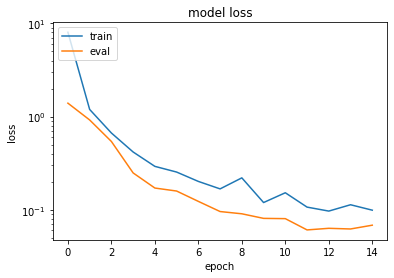

In [100]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

In [101]:
Input_dir='../data/raw_images/sample'
files = glob.glob(Input_dir + '/*.bmp')

In [102]:
for file in files[:100]: 
    base = os.path.basename(file)
    target = base[0:1]
    image_bmp = Image.open(file)
    test_image = np.array(image_bmp, dtype="float32")
    img = np.reshape(test_image,[1,25,15,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    print(file[:27], classes)
    

../data/raw_images/sample/5 6
../data/raw_images/sample/8 8
../data/raw_images/sample/7 7
../data/raw_images/sample/7 7
../data/raw_images/sample/0 8
../data/raw_images/sample/9 8
../data/raw_images/sample/2 5
../data/raw_images/sample/7 7
../data/raw_images/sample/5 6
../data/raw_images/sample/9 9
../data/raw_images/sample/9 9
../data/raw_images/sample/5 5
../data/raw_images/sample/6 6
../data/raw_images/sample/8 8
../data/raw_images/sample/4 8
../data/raw_images/sample/6 6
../data/raw_images/sample/3 3
../data/raw_images/sample/0 8
../data/raw_images/sample/3 3
../data/raw_images/sample/6 6
../data/raw_images/sample/1 1
../data/raw_images/sample/5 6
../data/raw_images/sample/4 8
../data/raw_images/sample/3 3
../data/raw_images/sample/0 8
../data/raw_images/sample/1 1
../data/raw_images/sample/3 3
../data/raw_images/sample/8 8
../data/raw_images/sample/4 4
../data/raw_images/sample/2 5
../data/raw_images/sample/0 8
../data/raw_images/sample/5 6
../data/raw_images/sample/2 6
../data/ra

In [ ]:
0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.8157, 0.7529, 0.8627, 0.8157, 0.7529, 0.8627, 0.8157, 0.7216, 0.8627, 0.8157, 0.7216, 0.8627, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.7843, 0.7529, 0.6588, 0.7373, 0.7216, 0.7216, 0.8471, 0.7843, 0.7216, 0.8627, 0.7843, 0.7216, 0.8627, 0.7843, 0.7529, 0.8627, 0.8157, 0.7216, 0.8627, 0.8157, 0.7216, 0.8471, 0.7843, 0.7216, 0.8314, 0.7843, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8627, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8314, 0.7843, 0.7216, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.8000, 0.7529, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.7216, 0.8314, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.6902, 0.8314, 0.7843, 0.6902, 0.8000, 0.7529, 0.6588, 0.7686, 0.7529, 0.6588, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6588, 0.7529, 0.6902, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8314, 0.7529, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7843, 0.6588, 0.8000, 0.7529, 0.6588, 0.7529, 0.7529, 0.6275, 0.7373, 0.7216, 0.6275, 0.7059, 0.7216, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7216, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7529, 0.6902, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8000, 0.7843, 0.6275, 0.7529, 0.7216, 0.6275, 0.7216, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7216, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.7216, 0.7216, 0.6588, 0.7529, 0.7529, 0.6588, 0.8000, 0.7529, 0.6588, 0.8000, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.7059, 0.6902, 0.6588, 0.7216, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.7373, 0.6902, 0.6902, 0.7843, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.6902, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7843, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6902, 0.7843, 0.7529, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8000, 0.7529, 0.6275, 0.7529, 0.6902, 0.5961, 0.6902, 0.6588, 0.6275, 0.7216, 0.6902, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7686, 0.7529, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6902, 0.7843, 0.7843, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.6902, 0.5961, 0.6902, 0.6588, 0.6275, 0.7216, 0.6902, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7529, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7373, 0.6902, 0.6902, 0.7843, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.6902, 0.5961, 0.6902, 0.6588, 0.6588, 0.7373, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7686, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7373, 0.6902, 0.6902, 0.7686, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7529, 0.7216, 0.6902, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7686, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7216, 0.6902, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7529, 0.7216, 0.6588, 0.7529, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7373, 0.6902, 0.6588, 0.7686, 0.7216, 0.6902, 0.8000, 0.7529, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7843, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7216, 0.7216, 0.6588, 0.7686, 0.7216, 0.6902, 0.7843, 0.7529, 0.6902, 0.8000, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6588, 0.7529, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7216, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7216, 0.6902, 0.6275, 0.7216, 0.7216, 0.6588, 0.7529, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7686, 0.6902, 0.6275, 0.7059, 0.6588, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.8000, 0.7216, 0.6902, 0.7843, 0.7216, 0.6902, 0.7843, 0.7529, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.7216, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7529, 0.7216, 0.6588, 0.7373, 0.6902, 0.6275, 0.7059, 0.6588, 0.6902, 0.8000, 0.7216, 0.6588, 0.8000, 0.7216, 0.6902, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6902, 0.8000, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.7843, 0.7216, 0.6588, 0.7373, 0.7216, 0.5961, 0.6902, 0.6588, 0.6275, 0.7059, 0.6588, 0.6588, 0.7373, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7373, 0.6902, 0.6275, 0.7059, 0.6588, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7843, 0.7216, 0.6902, 0.8000, 0.7216, 0.6902, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6275, 0.7216, 0.6902, 0.5961, 0.6745, 0.6588, 0.6275, 0.6902, 0.6588, 0.6588, 0.7216, 0.6902, 0.6588, 0.7373, 0.6902, 0.6588, 0.7216, 0.6902, 0.6275, 0.6902, 0.6588, 0.6588, 0.7529, 0.6902, 0.6588, 0.7529, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7529, 0.6902, 0.6275, 0.6902, 0.6588, 0.5961, 0.6588, 0.6588, 0.5961, 0.6745, 0.6588, 0.6275, 0.7059, 0.6902, 0.6588, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.6902, 0.6588, 0.6588, 0.7373, 0.6902, 0.6588, 0.7373, 0.6902, 0.6588, 0.7216, 0.6902, 0.6588, 0.7216, 0.6902, 0.6588, 0.7529, 0.6902, 0.6588, 0.7529, 0.6902, 0.6588, 0.7373, 0.6902, 0.6275, 0.7059, 0.6902, 0.5961, 0.6745, 0.6588, 0.5647, 0.6588, 0.6275, 0.5961, 0.6745, 0.6275, 0.6275, 0.7059, 0.6588, 0.6275, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.6275, 0.6745, 0.6275, 0.6588, 0.7216, 0.6902, 0.6588, 0.7216, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.6902, 0.6588, 0.6275, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.6275, 0.6902, 0.6588, 0.5961, 0.6745, 0.6275, 0.5647, 0.6588, 0.5961, 0.5333, 0.6431, 0.5961, 0.5647, 0.6588, 0.6275, 0.5961, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.6275, 0.6902, 0.6588, 0.5961, 0.6745, 0.6275, 0.6275, 0.7059, 0.6588, 0.6275, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.5961, 0.6745, 0.6275, 0.5647, 0.6588, 0.5961, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5961, 0.5333, 0.6431, 0.5961, 0.5333, 0.6275, 0.5647, 0.5647, 0.6431, 0.5961, 0.5961, 0.6902, 0.6275, 0.5961, 0.6745, 0.6275, 0.5961, 0.6588, 0.6275, 0.5961, 0.6588, 0.5961, 0.5961, 0.6745, 0.6275, 0.5961, 0.6745, 0.6275, 0.5961, 0.6745, 0.6275, 0.5647, 0.6431, 0.5961, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5333, 0.6118, 0.5647, 0.5333, 0.6275, 0.5647, 0.5647, 0.6431, 0.5647, 0.5647, 0.6588, 0.5961, 0.5647, 0.6588, 0.5961, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5647, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5961, 0.5333, 0.6431, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.4706, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.6118, 0.5333, 0.5333, 0.6275, 0.5647, 0.5333, 0.6275, 0.5647, 0.5647, 0.6275, 0.5647, 0.5333, 0.6275, 0.5647, 0.5333, 0.6275, 0.5647, 0.5333, 0.6118, 0.5647, 0.5333, 0.6275, 0.5647, 0.5333, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5804, 0.5333, 0.5020, 0.5804, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5333, 0.5961, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5333, 0.6118, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333

### Save the model

* Save the model to the file with the "h5" file format

## Post training weight quantization

* Depending on your requirements (performance, memory and runtime), post training quantization can be done in two ways.

Approach #1:  Post training weight quantization (quantizes weights only) In this case only weights are quantized to int8 but activations remain as they were. Inference input and output are floating-point.

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
# Post training quantization
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("digit_model_quant.tflite", "wb").write(tflite_quant_model)

2022-10-14 01:52:15.347649: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpnrg9d28g/assets


2022-10-14 01:52:15.903410: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-10-14 01:52:15.903573: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-14 01:52:15.905085: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.009ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-10-14 01:52:15.943949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-10-14 01:52:15.943999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2022-10-14 01:52:15.947120: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-10-14 01:52:1

62704

In [25]:
def representative_dataset():
    for n in range(10):
        data = np.expand_dims(x_data[5], axis=0)
        yield [data.astype(np.float32)]

Approach #2: Full integer quantization (Quantizes weights and activations) In this case weights and activations are quantized to int8. First we need to follow the approach #1 to quantize weight and then implement following code to do full integer quantization. This uses quantized input and output, making it compatible with more accelerators, such as the Openmv Camera and Coral Edge TPU. Inference input and output are integers.

In [26]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.dtypes.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()
open("digit_model_quant.tflite_int8.tflite", "wb").write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpglxxntnm/assets


INFO:tensorflow:Assets written to: /tmp/tmpglxxntnm/assets
2022-10-14 01:56:35.128291: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-10-14 01:56:35.128483: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-14 01:56:35.129911: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.006ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-10-14 01:56:35.169560: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-10-14 01:56:35.169589: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 9, output_inference_type: 9


61392

In [152]:
features = [0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.8157, 0.7529, 0.8627, 0.8157, 0.7529, 0.8627, 0.8157, 0.7216, 0.8627, 0.8157, 0.7216, 0.8627, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.7843, 0.7529, 0.6588, 0.7373, 0.7216, 0.7216, 0.8471, 0.7843, 0.7216, 0.8627, 0.7843, 0.7216, 0.8627, 0.7843, 0.7529, 0.8627, 0.8157, 0.7216, 0.8627, 0.8157, 0.7216, 0.8471, 0.7843, 0.7216, 0.8314, 0.7843, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8627, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8314, 0.7843, 0.7216, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.8000, 0.7529, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.7216, 0.8314, 0.7843, 0.7216, 0.8471, 0.7843, 0.7216, 0.8471, 0.7843, 0.6902, 0.8314, 0.7843, 0.6902, 0.8000, 0.7529, 0.6588, 0.7686, 0.7529, 0.6588, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6588, 0.7529, 0.6902, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8314, 0.7529, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7843, 0.6588, 0.8000, 0.7529, 0.6588, 0.7529, 0.7529, 0.6275, 0.7373, 0.7216, 0.6275, 0.7059, 0.7216, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7216, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7529, 0.6902, 0.6902, 0.8314, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8000, 0.7843, 0.6275, 0.7529, 0.7216, 0.6275, 0.7216, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7216, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.7216, 0.7216, 0.6588, 0.7529, 0.7529, 0.6588, 0.8000, 0.7529, 0.6588, 0.8000, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.7059, 0.6902, 0.6588, 0.7216, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.7373, 0.6902, 0.6902, 0.7843, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7529, 0.7216, 0.6275, 0.6902, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7843, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6902, 0.7843, 0.7529, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.8000, 0.7529, 0.6275, 0.7529, 0.6902, 0.5961, 0.6902, 0.6588, 0.6275, 0.7216, 0.6902, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7686, 0.7529, 0.6275, 0.7373, 0.7216, 0.6275, 0.7373, 0.7216, 0.6902, 0.7843, 0.7843, 0.7216, 0.8314, 0.7843, 0.6902, 0.8314, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.6902, 0.5961, 0.6902, 0.6588, 0.6275, 0.7216, 0.6902, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7529, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7373, 0.6902, 0.6902, 0.7843, 0.7529, 0.6902, 0.8314, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.6902, 0.5961, 0.6902, 0.6588, 0.6588, 0.7373, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7686, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7373, 0.6902, 0.6902, 0.7686, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.7843, 0.7529, 0.6275, 0.7373, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7529, 0.7216, 0.6902, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7216, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7686, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7216, 0.6902, 0.6588, 0.7373, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7529, 0.7216, 0.6588, 0.7529, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7373, 0.6902, 0.6588, 0.7686, 0.7216, 0.6902, 0.8000, 0.7529, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6588, 0.7843, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7216, 0.7216, 0.6588, 0.7686, 0.7216, 0.6902, 0.7843, 0.7529, 0.6902, 0.8000, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.6902, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6588, 0.7529, 0.7216, 0.6275, 0.7373, 0.6902, 0.6275, 0.7216, 0.7216, 0.6275, 0.7216, 0.6902, 0.6275, 0.7216, 0.6902, 0.6275, 0.7216, 0.7216, 0.6588, 0.7529, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7686, 0.6902, 0.6275, 0.7059, 0.6588, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8157, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.8000, 0.7216, 0.6902, 0.7843, 0.7216, 0.6902, 0.7843, 0.7529, 0.6588, 0.7843, 0.7216, 0.6588, 0.7373, 0.7216, 0.6275, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7529, 0.7216, 0.6588, 0.7373, 0.6902, 0.6275, 0.7059, 0.6588, 0.6902, 0.8000, 0.7216, 0.6588, 0.8000, 0.7216, 0.6902, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6588, 0.7843, 0.7216, 0.6902, 0.8000, 0.7529, 0.6902, 0.8000, 0.7529, 0.6902, 0.7843, 0.7216, 0.6588, 0.7373, 0.7216, 0.5961, 0.6902, 0.6588, 0.6275, 0.7059, 0.6588, 0.6588, 0.7373, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7373, 0.6902, 0.6275, 0.7059, 0.6588, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7843, 0.7216, 0.6902, 0.8000, 0.7216, 0.6902, 0.7843, 0.7216, 0.6588, 0.7686, 0.7216, 0.6275, 0.7216, 0.6902, 0.5961, 0.6745, 0.6588, 0.6275, 0.6902, 0.6588, 0.6588, 0.7216, 0.6902, 0.6588, 0.7373, 0.6902, 0.6588, 0.7216, 0.6902, 0.6275, 0.6902, 0.6588, 0.6588, 0.7529, 0.6902, 0.6588, 0.7529, 0.6902, 0.6588, 0.7529, 0.7216, 0.6588, 0.7373, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7686, 0.7216, 0.6588, 0.7529, 0.6902, 0.6275, 0.6902, 0.6588, 0.5961, 0.6588, 0.6588, 0.5961, 0.6745, 0.6588, 0.6275, 0.7059, 0.6902, 0.6588, 0.7059, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.6902, 0.6588, 0.6588, 0.7373, 0.6902, 0.6588, 0.7373, 0.6902, 0.6588, 0.7216, 0.6902, 0.6588, 0.7216, 0.6902, 0.6588, 0.7529, 0.6902, 0.6588, 0.7529, 0.6902, 0.6588, 0.7373, 0.6902, 0.6275, 0.7059, 0.6902, 0.5961, 0.6745, 0.6588, 0.5647, 0.6588, 0.6275, 0.5961, 0.6745, 0.6275, 0.6275, 0.7059, 0.6588, 0.6275, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.6275, 0.6745, 0.6275, 0.6588, 0.7216, 0.6902, 0.6588, 0.7216, 0.6902, 0.6275, 0.7059, 0.6902, 0.6275, 0.6902, 0.6588, 0.6275, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.6275, 0.6902, 0.6588, 0.5961, 0.6745, 0.6275, 0.5647, 0.6588, 0.5961, 0.5333, 0.6431, 0.5961, 0.5647, 0.6588, 0.6275, 0.5961, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.6275, 0.6902, 0.6588, 0.5961, 0.6745, 0.6275, 0.6275, 0.7059, 0.6588, 0.6275, 0.7059, 0.6588, 0.6275, 0.6902, 0.6588, 0.5961, 0.6745, 0.6275, 0.5647, 0.6588, 0.5961, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5961, 0.5333, 0.6431, 0.5961, 0.5333, 0.6275, 0.5647, 0.5647, 0.6431, 0.5961, 0.5961, 0.6902, 0.6275, 0.5961, 0.6745, 0.6275, 0.5961, 0.6588, 0.6275, 0.5961, 0.6588, 0.5961, 0.5961, 0.6745, 0.6275, 0.5961, 0.6745, 0.6275, 0.5961, 0.6745, 0.6275, 0.5647, 0.6431, 0.5961, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5333, 0.6118, 0.5647, 0.5333, 0.6275, 0.5647, 0.5647, 0.6431, 0.5647, 0.5647, 0.6588, 0.5961, 0.5647, 0.6588, 0.5961, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5647, 0.5647, 0.6431, 0.5961, 0.5647, 0.6431, 0.5961, 0.5333, 0.6431, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.4706, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.6118, 0.5333, 0.5333, 0.6275, 0.5647, 0.5333, 0.6275, 0.5647, 0.5647, 0.6275, 0.5647, 0.5333, 0.6275, 0.5647, 0.5333, 0.6275, 0.5647, 0.5333, 0.6118, 0.5647, 0.5333, 0.6275, 0.5647, 0.5333, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5804, 0.5333, 0.5020, 0.5804, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5333, 0.5961, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5333, 0.6118, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333]

In [153]:
features = [0.5020, 0.6118, 0.5333, 0.5020, 0.6431, 0.5647, 0.5333, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6431, 0.5333, 0.5020, 0.6431, 0.5333, 0.5020, 0.6431, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6431, 0.5333, 0.5020, 0.6431, 0.5333, 0.5020, 0.6431, 0.5333, 0.5020, 0.6431, 0.5647, 0.5020, 0.6118, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6431, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5333, 0.6431, 0.5647, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5333, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6431, 0.5333, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.4392, 0.5804, 0.5020, 0.4392, 0.5490, 0.5020, 0.4706, 0.5961, 0.5020, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5647, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.4706, 0.5961, 0.5020, 0.4078, 0.5333, 0.4392, 0.3765, 0.5176, 0.4392, 0.4392, 0.5804, 0.4706, 0.5020, 0.6118, 0.5020, 0.5020, 0.6275, 0.5333, 0.4706, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.4706, 0.6275, 0.5333, 0.4706, 0.6118, 0.5020, 0.4706, 0.6118, 0.5020, 0.4706, 0.6118, 0.5020, 0.4392, 0.5647, 0.4706, 0.3765, 0.5176, 0.4392, 0.3765, 0.5176, 0.4392, 0.4706, 0.5804, 0.4706, 0.5020, 0.6118, 0.5020, 0.5020, 0.6118, 0.5333, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.4706, 0.6118, 0.5333, 0.4706, 0.6275, 0.5333, 0.4706, 0.6275, 0.5020, 0.4706, 0.5961, 0.5333, 0.4392, 0.5647, 0.5020, 0.3765, 0.5020, 0.4392, 0.3765, 0.5176, 0.4706, 0.4706, 0.5961, 0.5020, 0.5020, 0.6118, 0.5020, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.4706, 0.6118, 0.5333, 0.4706, 0.6118, 0.5333, 0.4706, 0.5961, 0.5333, 0.4392, 0.5490, 0.5020, 0.3765, 0.5020, 0.4392, 0.3765, 0.5176, 0.4706, 0.4392, 0.5804, 0.5020, 0.4706, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.4706, 0.6118, 0.5333, 0.4706, 0.6118, 0.5333, 0.4706, 0.5961, 0.5333, 0.4078, 0.5490, 0.4706, 0.3765, 0.4863, 0.4392, 0.4078, 0.5176, 0.4706, 0.4706, 0.5961, 0.5020, 0.4706, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6118, 0.5333, 0.4706, 0.6118, 0.5333, 0.4078, 0.5490, 0.4706, 0.3765, 0.5020, 0.4392, 0.4078, 0.5333, 0.4706, 0.4706, 0.5961, 0.5020, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5333, 0.5020, 0.6275, 0.5333, 0.4706, 0.6118, 0.5333, 0.4392, 0.5647, 0.5020, 0.4078, 0.5176, 0.4706, 0.4392, 0.5490, 0.5020, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.4706, 0.5961, 0.5333, 0.4392, 0.5647, 0.5020, 0.4706, 0.5804, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.4706, 0.6275, 0.5647, 0.4706, 0.5961, 0.5333, 0.4392, 0.5804, 0.5020, 0.4706, 0.5961, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5333, 0.5020, 0.6118, 0.5333, 0.4706, 0.5961, 0.5333, 0.4078, 0.5490, 0.4706, 0.4078, 0.5333, 0.4706, 0.4392, 0.5804, 0.5020, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.4706, 0.6118, 0.5333, 0.4392, 0.5804, 0.5333, 0.3765, 0.5176, 0.4392, 0.3765, 0.5176, 0.4392, 0.4706, 0.5804, 0.5020, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.4706, 0.6118, 0.5333, 0.4392, 0.5804, 0.5020, 0.3765, 0.5176, 0.4392, 0.3765, 0.5176, 0.4392, 0.4706, 0.5804, 0.5020, 0.5020, 0.6275, 0.5333, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5333, 0.5020, 0.6275, 0.5333, 0.4706, 0.5647, 0.5020, 0.4078, 0.5176, 0.4706, 0.4078, 0.5176, 0.4706, 0.4706, 0.5804, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.4706, 0.6275, 0.5333, 0.4392, 0.5647, 0.5020, 0.4078, 0.5176, 0.4392, 0.4078, 0.5333, 0.4706, 0.4706, 0.5961, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5333, 0.4392, 0.5647, 0.5020, 0.4078, 0.5176, 0.4706, 0.4078, 0.5490, 0.5020, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5333, 0.4706, 0.5804, 0.5333, 0.4078, 0.5333, 0.5020, 0.4392, 0.5647, 0.5020, 0.4706, 0.6118, 0.5333, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6431, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.4706, 0.5961, 0.5333, 0.4392, 0.5647, 0.5020, 0.4392, 0.5804, 0.5333, 0.4706, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5647, 0.5020, 0.6118, 0.5333, 0.4706, 0.5961, 0.5333, 0.4706, 0.5961, 0.5333, 0.5020, 0.6118, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.6275, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5804, 0.5647, 0.5020, 0.5804, 0.5647, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.4706, 0.5961, 0.5333, 0.4706, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.5961, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.5020, 0.6118, 0.5333, 0.4706, 0.5804, 0.5020, 0.4706, 0.5804, 0.5020, 0.4706, 0.5647, 0.5020, 0.4706, 0.5647, 0.5020, 0.4706, 0.5647, 0.5333, 0.4706, 0.5647, 0.5333, 0.4706, 0.5804, 0.5020, 0.4706, 0.5804, 0.5020, 0.4706, 0.5804, 0.5333, 0.4706, 0.5804, 0.5020, 0.4706, 0.5804, 0.5020, 0.5020, 0.5804, 0.5020, 0.4706, 0.5804, 0.5020, 0.4706, 0.5961, 0.5020, 0.4706, 0.5804, 0.5020]

In [197]:
# model_path = "digit_model_quant.tflite"
model_path = "digit_model_quant.tflite_int8.tflite"

In [198]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=model_path)

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [199]:
# Allocate tensors
interpreter.allocate_tensors()

# Print the input and output details of the model
print()
print("Input details:")
print(input_details)
print()
print("Output details:")
print(output_details)
print()


Input details:
[{'name': 'input_6', 'index': 0, 'shape': array([ 1, 25, 15,  3], dtype=int32), 'shape_signature': array([-1, 25, 15,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0013533256715163589, -128), 'quantization_parameters': {'scales': array([0.0014], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Output details:
[{'name': 'Identity', 'index': 21, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.0039], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]



In [200]:
# Convert features to NumPy array
np_features = np.array(features)
np_features = np_features.reshape(25,15,3)

# If the expected input type is int8 (quantized model), rescale data
input_type = input_details[0]['dtype']
if input_type == np.int8:
    input_scale, input_zero_point = input_details[0]['quantization']
    print("Input scale:", input_scale)
    print("Input zero point:", input_zero_point)
    print()
    np_features = (np_features / input_scale) + input_zero_point
    np_features = np.around(np_features)
    

Input scale: 0.0013533256715163589
Input zero point: -128



In [201]:
# Convert features to NumPy array of expected type
np_features = np_features.astype(input_type)

# Add dimension to input sample (TFLite model expects (# samples, data))
np_features = np.expand_dims(np_features, axis=0)

In [202]:
# Create input tensor out of raw features
interpreter.set_tensor(input_details[0]['index'], np_features)

# Run inference
interpreter.invoke()


In [203]:
# output_details[0]['index'] = the index which provides the input
output = interpreter.get_tensor(output_details[0]['index'])


In [204]:
# If the output type is int8 (quantized model), rescale data
output_type = output_details[0]['dtype']
if output_type == np.int8:
    output_scale, output_zero_point = output_details[0]['quantization']
    print("Raw output scores:", output)
    print("Output scale:", output_scale)
    print("Output zero point:", output_zero_point)
    print()
    output = output_scale * (output.astype(np.float32) - output_zero_point)

# Print the results of inference
print("Inference output:", output)

Raw output scores: [[-119  105 -128 -119 -128 -128 -122 -128 -128 -128]]
Output scale: 0.00390625
Output zero point: -128

Inference output: [[0.0352 0.9102 0.     0.0352 0.     0.     0.0234 0.     0.     0.    ]]


In [196]:
# If the output type is int8 (quantized model), rescale data
output_type = output_details[0]['dtype']
if output_type == np.int8:
    output_scale, output_zero_point = output_details[0]['quantization']
    print("Raw output scores:", output)
    print("Output scale:", output_scale)
    print("Output zero point:", output_zero_point)
    print()
    output = output_scale * (output.astype(np.float32) - output_zero_point)

# Print the results of inference
print("Inference output:", output)

Inference output: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [174]:
Input_dir='/home/george/Documents/2022/tinyml/presentation/tiny-fsdl/ml/data/raw_images/fine/1_1_2affa617-0eca-431a-91a1-02d742f67213.jpg'

In [175]:
test_image = Image.open(Input_dir)
test_image = np.array(test_image, dtype="float32")

In [176]:
type(features)

list

In [177]:
feature = np.array(features).reshape(25,15,3)
# new_feat = features.
feature

array([[[0.502 , 0.6118, 0.5333],
        [0.502 , 0.6431, 0.5647],
        [0.5333, 0.6431, 0.5647],
        ...,
        [0.502 , 0.6431, 0.5333],
        [0.502 , 0.6431, 0.5333],
        [0.502 , 0.6431, 0.5647]],

       [[0.502 , 0.6118, 0.5333],
        [0.502 , 0.6275, 0.5647],
        [0.502 , 0.6275, 0.5647],
        ...,
        [0.502 , 0.6275, 0.5647],
        [0.502 , 0.6431, 0.5647],
        [0.5333, 0.6431, 0.5647]],

       [[0.4706, 0.6118, 0.5333],
        [0.502 , 0.6275, 0.5333],
        [0.502 , 0.6275, 0.5333],
        ...,
        [0.502 , 0.6275, 0.5333],
        [0.502 , 0.6275, 0.5647],
        [0.502 , 0.6431, 0.5333]],

       ...,

       [[0.502 , 0.6275, 0.5647],
        [0.502 , 0.6275, 0.5647],
        [0.502 , 0.6275, 0.5647],
        ...,
        [0.502 , 0.6275, 0.5647],
        [0.502 , 0.6275, 0.5647],
        [0.502 , 0.6275, 0.5647]],

       [[0.502 , 0.5961, 0.5333],
        [0.502 , 0.5961, 0.5333],
        [0.502 , 0.5961, 0.5333],
        .

In [180]:
test_image

array([[[126., 158., 137.],
        [132., 164., 141.],
        [132., 164., 141.],
        ...,
        [130., 163., 142.],
        [129., 163., 139.],
        [131., 165., 141.]],

       [[123., 155., 134.],
        [129., 161., 138.],
        [129., 161., 138.],
        ...,
        [127., 160., 139.],
        [128., 162., 138.],
        [132., 166., 142.]],

       [[123., 155., 134.],
        [129., 161., 138.],
        [128., 160., 137.],
        ...,
        [127., 160., 139.],
        [127., 161., 137.],
        [131., 165., 141.]],

       ...,

       [[129., 160., 142.],
        [129., 160., 142.],
        [129., 160., 142.],
        ...,
        [128., 159., 141.],
        [129., 160., 142.],
        [129., 160., 142.]],

       [[125., 154., 136.],
        [125., 154., 136.],
        [125., 154., 136.],
        ...,
        [127., 156., 138.],
        [127., 156., 138.],
        [127., 156., 138.]],

       [[120., 147., 128.],
        [119., 146., 129.],
        [118., 1

In [172]:
img = np.reshape(test_image,[1,25,15,3])
classes = np.argmax(model.predict(img), axis=-1)
classes

array([1])

In [178]:
test_image / 255

array([[[0.4941, 0.6196, 0.5373],
        [0.5176, 0.6431, 0.5529],
        [0.5176, 0.6431, 0.5529],
        ...,
        [0.5098, 0.6392, 0.5569],
        [0.5059, 0.6392, 0.5451],
        [0.5137, 0.6471, 0.5529]],

       [[0.4824, 0.6078, 0.5255],
        [0.5059, 0.6314, 0.5412],
        [0.5059, 0.6314, 0.5412],
        ...,
        [0.498 , 0.6275, 0.5451],
        [0.502 , 0.6353, 0.5412],
        [0.5176, 0.651 , 0.5569]],

       [[0.4824, 0.6078, 0.5255],
        [0.5059, 0.6314, 0.5412],
        [0.502 , 0.6275, 0.5373],
        ...,
        [0.498 , 0.6275, 0.5451],
        [0.498 , 0.6314, 0.5373],
        [0.5137, 0.6471, 0.5529]],

       ...,

       [[0.5059, 0.6275, 0.5569],
        [0.5059, 0.6275, 0.5569],
        [0.5059, 0.6275, 0.5569],
        ...,
        [0.502 , 0.6235, 0.5529],
        [0.5059, 0.6275, 0.5569],
        [0.5059, 0.6275, 0.5569]],

       [[0.4902, 0.6039, 0.5333],
        [0.4902, 0.6039, 0.5333],
        [0.4902, 0.6039, 0.5333],
        .

In [179]:
img = np.reshape(test_image,[1,25,15,3])
classes = np.argmax(model.predict(img), axis=-1)
classes

array([1])